## 5. WAV 파일 길이 분포 검토


⏱️ 파일 길이 통계 (초):
count    18048.000000
mean         8.561419
std         10.227405
min          0.291995
25%          2.770748
50%          4.971995
75%          8.900000
max         60.000000
Name: duration, dtype: float64


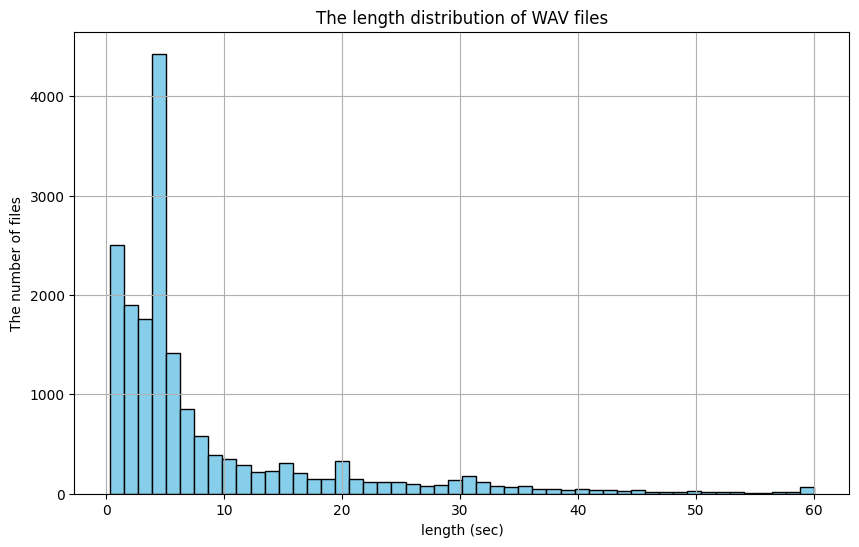


⚠️ 길이 범위를 벗어난 파일 개수: 4515

⚠️ 길이 범위를 벗어난 파일 목록 (상위 20개):
파일: 2.motorcycle_horn_85080_1.wav, 길이: 39.00초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_85080_1.wav
파일: 2.motorcycle_horn_35046_1.wav, 길이: 11.85초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_35046_1.wav
파일: 2.motorcycle_horn_82997_1.wav, 길이: 19.74초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_82997_1.wav
파일: 2.motorcycle_horn_85055_1.wav, 길이: 47.26초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_85055_1.wav
파일: 2.motorcycle_horn_83036_1.wav, 길이: 19.98초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_83036_1.wav
파일: 2.motorcycle_horn_83000_1.wav, 길이: 19.92초, 경로: /home/ubuntu/data/test_data/raw_data_test/2.Motorcycle/4.horn_of_motorcycle/2.motorcycle_horn_83000_1.wav


In [1]:
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt

# 검사할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 샘플링 레이트 및 오디오 데이터 획득
                y, sr = librosa.load(file_path, sr=None, mono=False)
                
                # 파일 길이 계산 (초 단위)
                duration = librosa.get_duration(y=y, sr=sr)
                
                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "duration": duration
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 길이 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "duration": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["duration"].notnull()]

# 파일 길이 통계
duration_stats = df_valid["duration"].describe()
print("\n⏱️ 파일 길이 통계 (초):")
print(duration_stats)

# 파일 길이의 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(df_valid["duration"], bins=50, color='skyblue', edgecolor='black')
plt.title('The length distribution of WAV files')
plt.xlabel('length (sec)')
plt.ylabel('The number of files')
plt.grid(True)
plt.show()

# 특정 길이 범위를 벗어나는 파일 찾기 (예: 1초 미만 또는 10초 초과)
min_duration = 1.0  # 최소 길이 (초)
max_duration = 10.0  # 최대 길이 (초)

out_of_range_files = df_valid[(df_valid["duration"] < min_duration) | (df_valid["duration"] > max_duration)]

# 상위 20개 파일만 선택
top_out_of_range_files = out_of_range_files.head(20)

num_out_of_range = len(out_of_range_files)
print(f"\n⚠️ 길이 범위를 벗어난 파일 개수: {num_out_of_range}")

if not top_out_of_range_files.empty:
    print(f"\n⚠️ 길이 범위를 벗어난 파일 목록 (상위 20개):")
    for idx, row in top_out_of_range_files.iterrows():
        print(f"파일: {row['file_name']}, 길이: {row['duration']:.2f}초, 경로: {row['file_path']}")

# 필요에 따라 CSV로 결과 저장 (선택사항)
# df.to_csv("audio_duration_info.csv", index=False)

### ⚠️ 음성 데이터 길이 범위 모델링 시 유의 필요

> 모델의 목적과 요구사항 파악

- 음성 인식 모델: 일반적으로 1초 이상의 음성이 필요하며, 너무 긴 음성은 모델 복잡도를 증가시킬 수 있어요.
- 이벤트 감지 모델: 특정 소리나 이벤트를 탐지하는 경우, 짧은 음성도 유용할 수 있어요.
- 클래스 불균형 고려: 길이에 따라 데이터의 클래스 분포가 달라질 수 있으니, 길이와 클래스 간의 상관관계를 검토해 보세요.

> 짧은 음성 파일 처리(1초 미만)
- 장점: 특정 순간의 소리를 포착할 수 있어요.
- 단점: 모델 학습에 충분한 정보가 없을 수 있어요.
- 추천: 내용이 유의미하다면 포함하고, 그렇지 않다면 제외하거나 보강이 필요할 수 있어요.

> 긴 음성 파일 처리(10초 초과)
- 장점: 풍부한 정보와 맥락을 제공해요.
- 단점: 모델의 학습 시간이 늘어나고, 과적합 위험이 있어요.


📊 클래스별 파일 수:
class_label
2.Motorcycle/5.driving_sound_of_motorcycle    5233
2.Motorcycle/4.horn_of_motorcycle             5079
1.Car/1.horn_of_car                           3588
1.Car/2.siren_of_car                          2239
1.Car/3.driving_sound_of_car                  1909
Name: count, dtype: int64

⏱️ 클래스별 파일 길이 통계 (초):
                                             count       mean        std  \
class_label                                                                
1.Car/1.horn_of_car                         3588.0   8.540623  10.606483   
1.Car/2.siren_of_car                        2239.0  14.396362  11.261600   
1.Car/3.driving_sound_of_car                1909.0  16.505118  15.966026   
2.Motorcycle/4.horn_of_motorcycle           5079.0   6.018488   8.718057   
2.Motorcycle/5.driving_sound_of_motorcycle  5233.0   5.649362   3.215988   

                                                 min       25%        50%  \
class_label                                                 

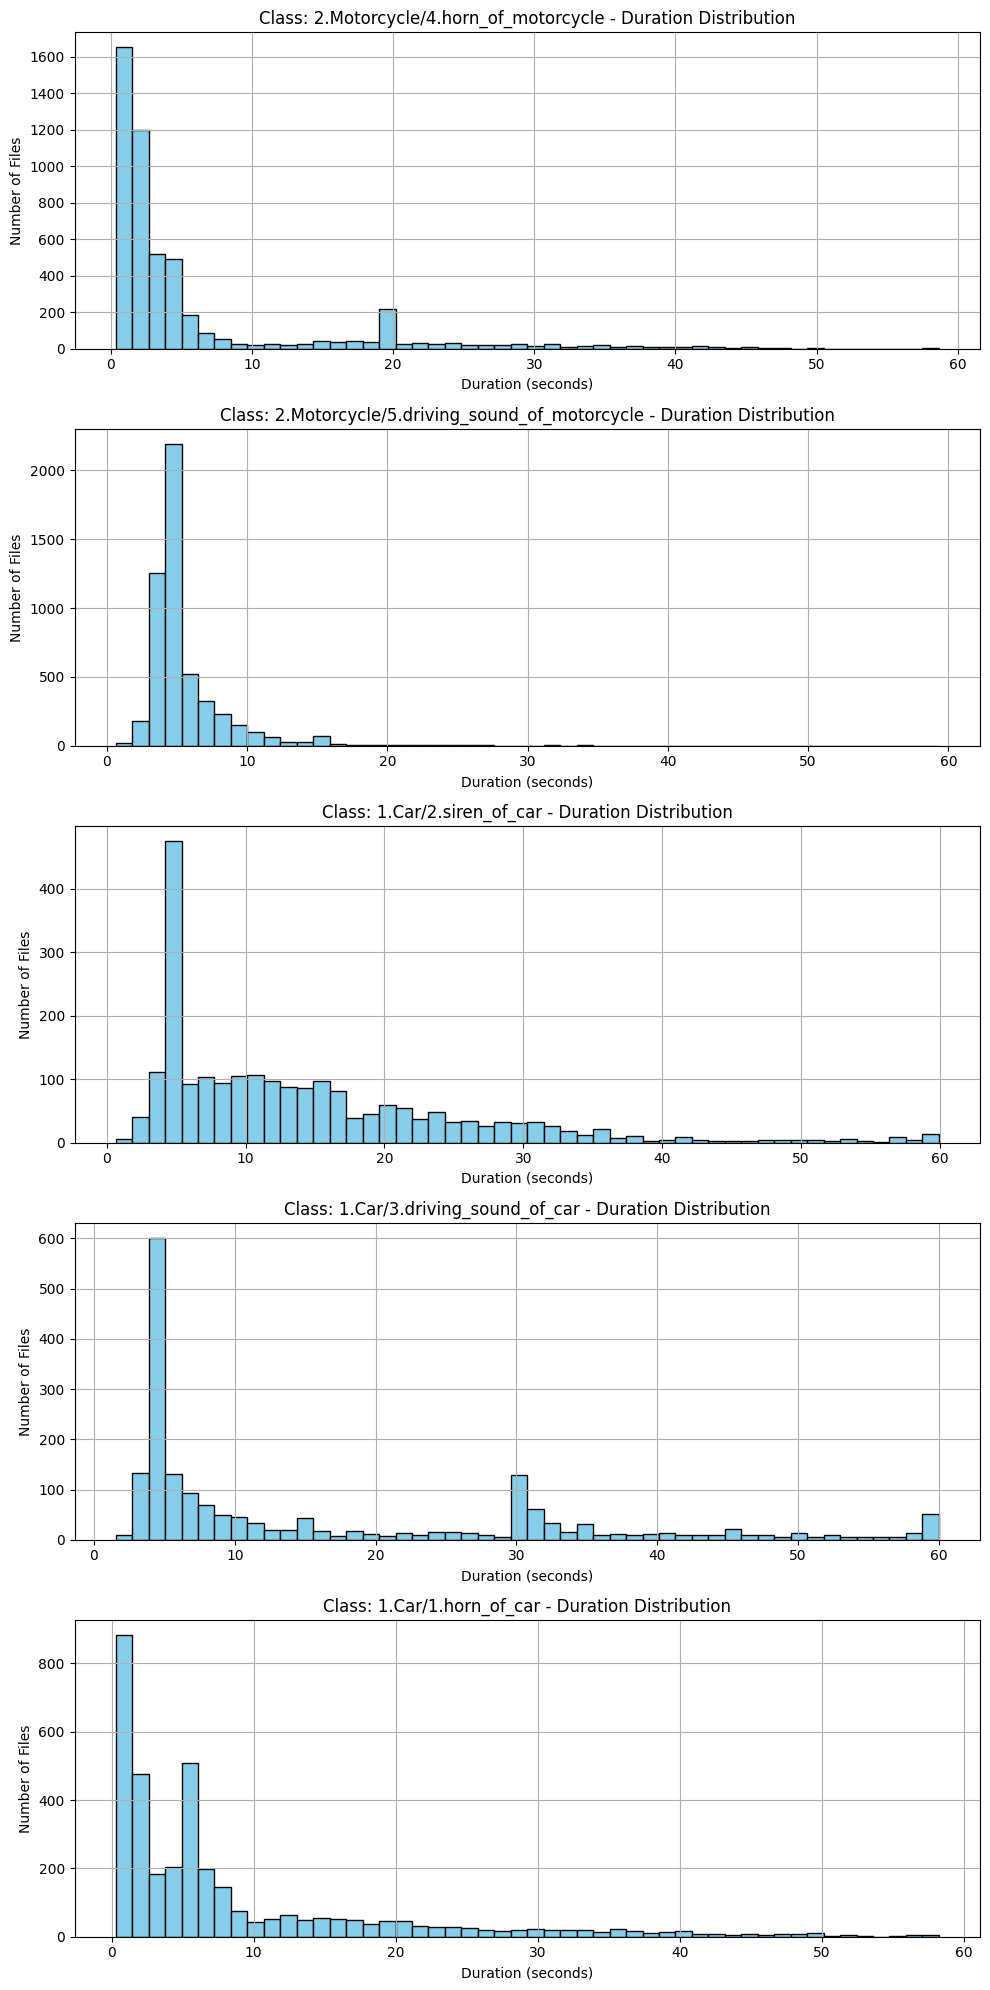

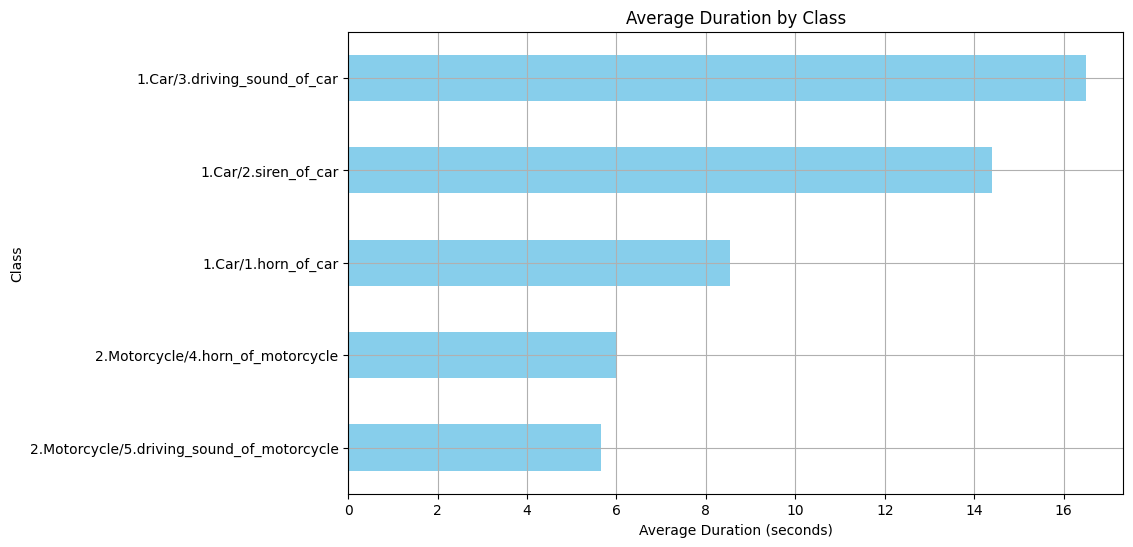

In [2]:
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt

# 검사할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 샘플링 레이트 및 오디오 데이터 획득
                y, sr = librosa.load(file_path, sr=None, mono=False)
                
                # 파일 길이 계산 (초 단위)
                duration = librosa.get_duration(y=y, sr=sr)

                # 클래스 정보 추출 (예시로, 상위 2개의 폴더 이름을 사용)
                path_parts = os.path.normpath(file_path).split(os.sep)
                class_label = os.path.join(path_parts[-3], path_parts[-2])  # 예: '2.Motorcycle/4.horn_of_motorcycle'

                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "duration": duration,
                    "class_label": class_label
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 길이 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "duration": None,
                    "class_label": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["duration"].notnull()]

# 클래스별 파일 수 확인
class_counts = df_valid["class_label"].value_counts()
print("\n📊 클래스별 파일 수:")
print(class_counts)

# 클래스별 파일 길이 통계 계산
class_duration_stats = df_valid.groupby("class_label")["duration"].describe()
print("\n⏱️ 클래스별 파일 길이 통계 (초):")
print(class_duration_stats)

# 클래스별 파일 길이 분포 시각화
unique_classes = df_valid["class_label"].unique()
num_classes = len(unique_classes)

# 그래프 크기 설정
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 4*num_classes))

if num_classes == 1:
    axes = [axes]  # 클래스가 하나인 경우에도 리스트로 만들기

for i, class_label in enumerate(unique_classes):
    class_data = df_valid[df_valid["class_label"] == class_label]
    axes[i].hist(class_data["duration"], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Class: {class_label} - Duration Distribution')
    axes[i].set_xlabel('Duration (seconds)')
    axes[i].set_ylabel('Number of Files')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# 클래스별 평균 파일 길이 막대 그래프
mean_durations = df_valid.groupby("class_label")["duration"].mean().sort_values()

plt.figure(figsize=(10, 6))
mean_durations.plot(kind='barh', color='skyblue')
plt.title('Average Duration by Class')
plt.xlabel('Average Duration (seconds)')
plt.ylabel('Class')
plt.grid(True)
plt.show()